In [1]:
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
import sys

sys.path.append(os.path.expanduser("src"))

from exp.datafactory import load_lbsn_artefacts, load_util_artefacts, load_aset_artefacts

# plt.style.use("matplotlib.mplstyle")  # TODO: comment it
%config InlineBackend.figure_format="retina"
%matplotlib inline

### Environment plan

In [2]:
# -------------------------------------------------------------------------

city = f"Rome"  # options available: "Rome", "Florence", "Istanbul"
lbsn_file = f"out/{city}_lbsn.hdf5"
util_file = f"out/{city}_util.hdf5"
aset_file = f"out/{city}_aset.hdf5"

# -------------------------------------------------------------------------

y, f, _, envstruct = load_lbsn_artefacts(lbsn_file)

N = len(y)
J = len(f)
N, J

(3150, 234)

In [ ]:

# for debug
tau_arr, tau_bias_arr = [], []
eta_arr, eta_bias_arr = [], []

# for fine-grained debug
simulation_lift_dict = {}
simulation_bias_dict = {}

keys = ["wmf", "vae", "ease"]
for key in keys:
    
    simulation_lift_dict[key] = {
        "user": {},
        "harm": {},
    }
    simulation_bias_dict[key] = {
        "user": {k: [] for k in (4, 8, 12, 16, 20)},
        "harm": {k: [] for k in (4, 8, 12, 16, 20)},
    }
    
    for recommender_system_key in set(["wmf", "vae", "ease"]):

        with open(f"out/experiments/runx_{city}_{key}_{recommender_system_key}.pk", "rb") as file:
            experiment = pickle.load(file)

        marker = "+"
        colors = ["r", "g", "b", "y", "m", "c", "pink", "orange"]
        
        for t in (2, 3, 4):
            for color_ix, a_size in enumerate(experiment[t].keys()):
                
                source = experiment[t][a_size]
                tau, tau_bias = source["improvement_user"], source["bias_improvement_user"]
                eta, eta_bias = source["improvement_harm"], source["bias_improvement_harm"]
                
                # collect uplift
                tau_arr.append(tau)
                eta_arr.append(eta)
                # collect biases
                tau_bias_arr.append(tau_bias)
                eta_bias_arr.append(eta_bias)
                # collect fine-grained uplift and biases
                simulation_lift_dict[key]["user"][(recommender_system_key,t,a_size)] = tau
                simulation_lift_dict[key]["harm"][(recommender_system_key,t,a_size)] = eta
                simulation_bias_dict[key]["user"][a_size].extend(tau_bias)
                simulation_bias_dict[key]["harm"][a_size].extend(eta_bias)

# data flatten
tau_flatten_arr = np.array(tau_arr).ravel()
eta_flatten_arr = np.array(eta_arr).ravel()

# bias flatten
tau_bias_flatten_arr = np.array(tau_bias_arr).ravel()
eta_bias_flatten_arr = np.array(eta_bias_arr).ravel()

# average uplift (average over t and a_size and key - recommender_system_key pairs)
average_tau_arr = np.mean(tau_arr, axis=0)
average_eta_arr = np.mean(eta_arr, axis=0)


In [4]:
coef = 100  # --> [%]


for key in ["wmf", "vae","ease"]:
    key = key.lower()
    abs = 0
    
    v_arr = []
    for k, data in simulation_bias_dict[key]["user"].items():
        v_arr.extend(data)
    string1 = f"user={np.mean(v_arr)*coef: .1f} (+/- {np.std(v_arr)*coef:.1f})"
    
    abs += np.abs(np.mean(v_arr)*coef)
    
    v_arr = []
    for k, data in simulation_bias_dict[key]["harm"].items():
        v_arr.extend(data)
    string2 = f"harm={np.mean(v_arr)*coef: .1f} (+/- {np.std(v_arr)*coef:.1f})"
    
    abs += np.abs(np.mean(v_arr)*coef)
    
    print(f"{key:<4s}: " + string1 + " " + string2 + f" | sum= {abs:>6.3f} [%]")

wmf : user=-3.1 (+/- 0.2) harm=-1.4 (+/- 0.5) | sum=  4.503 [%]
vae : user=-7.5 (+/- 1.0) harm=-0.7 (+/- 0.3) | sum=  8.261 [%]
ease: user=-2.2 (+/- 0.4) harm= 0.0 (+/- 0.1) | sum=  2.196 [%]


# ---

In [5]:
# this parameter defines the algorithm (key) that achieves the least bias in
# both dimensions: (tau_bias, eta_bias)
# the least bias guaranties the most trustworthy simulation results

BEST_KEY = "ease"

arr_t = {t: ([], []) for t in (2, 3, 4)}
arr_k = {k: ([], []) for k in (4, 8, 12, 16, 20)}

for (recommender_system_key, t, k), v in simulation_lift_dict[BEST_KEY]["user"].items():
    arr_t[t][0].append(v)
    arr_k[k][0].append(v)

for (recommender_system_key, t, k), v in simulation_lift_dict[BEST_KEY]["harm"].items():
    arr_t[t][1].append(v)
    arr_k[k][1].append(v)

C:\Users\ofirbend\AppData\Local\Temp\ipykernel_25940\2192768066.py:94: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


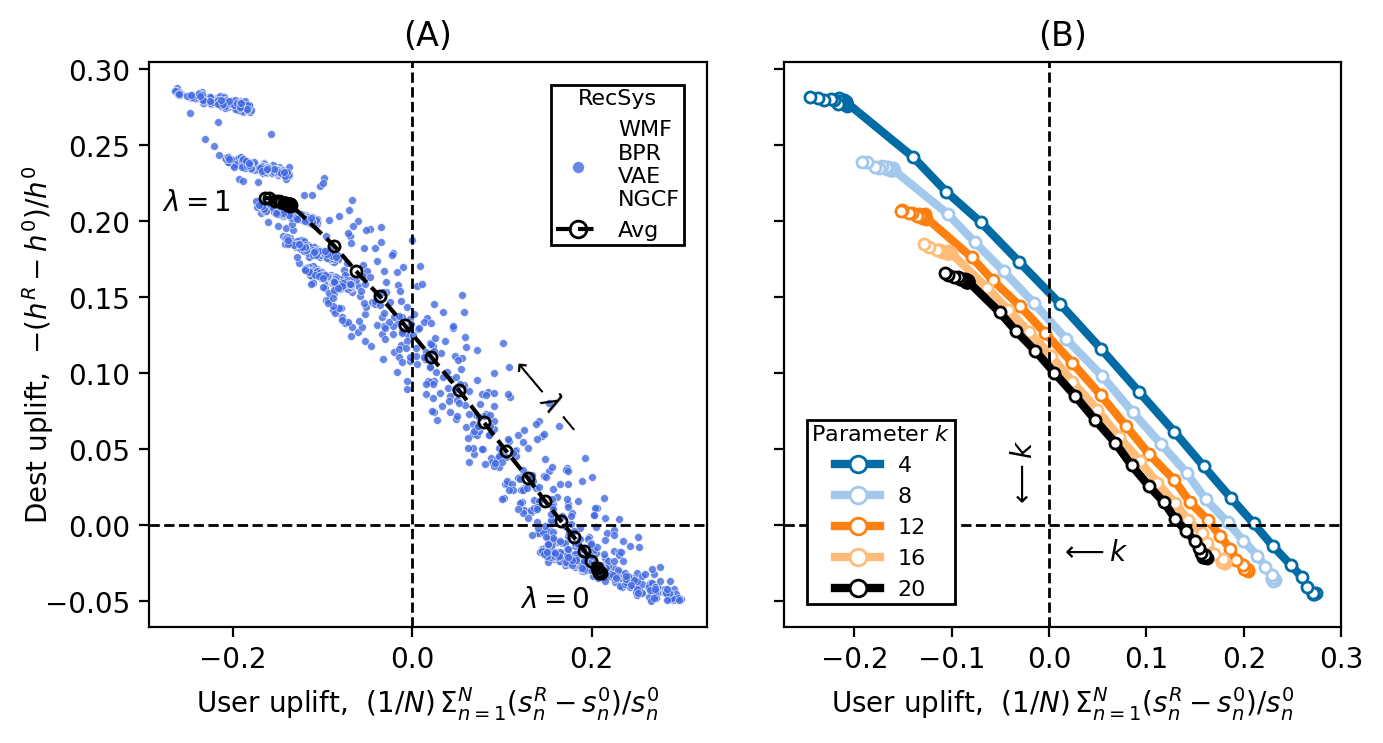

In [ ]:
xmax = 6.8
ymax = 3.6

fig = plt.figure(figsize=(xmax, ymax), layout="constrained")

gs = gridspec.GridSpec(
    1, 8,
    figure=fig, wspace=0.4, hspace=0.01,  # set the spacing between axes
)

bx = fig.add_subplot(gs[0,0:4])
ax = fig.add_subplot(gs[0,4: ], sharey=bx)

ax.tick_params(bottom=1, labelbottom=1, left=1, labelleft=0, which="both")

# >>>
colors = ["#006ba4", "#a2c8ec", "#ff800e", "#ffbc79", "#000000", "#595959"]

for i, k in enumerate(sorted(arr_k.keys())):
    ax.plot(
        np.mean(arr_k[k][0], axis=0),
        np.mean(arr_k[k][1], axis=0),
        color=colors[i],
        label=k, lw=3.0, ls="-", alpha=1.0, 
        marker="o", ms=4.0, mec=colors[i], mfc="w",  # markeredgewidth=2.5,
    )
ax.axvline(x=0, color="k", ls="--", lw=1.0)
ax.axhline(y=0, color="k", ls="--", lw=1.0)

ax.legend(loc="lower left", title=r"Parameter $k$", fontsize=8, title_fontsize=8, framealpha=1.0,
          markerscale=1.5, borderaxespad=1, frameon=1, fancybox=0,
          shadow=0, edgecolor="k", borderpad=0.2)

ax.set_xlabel(r"User uplift,  $(1/N) \, \Sigma_{n=1}^N (s_n^{R} - s_n^{0}) / s_n^{0}$")

ax.set_title(r"(B)")

# >>>

my_tau = []
my_eta = []
for k, (taus, etas) in arr_k.items():
    my_tau.extend(taus)
    my_eta.extend(etas)

flat_tau = np.array(my_tau).ravel()
flat_eta = np.array(my_eta).ravel()

# downsampling for vis purposes only
random_index = np.random.choice(len(flat_tau), size=int(len(flat_tau)//1.2), replace=False)

h = sns.scatterplot(
    x=flat_tau[random_index],
    y=flat_eta[random_index],
    marker="o", s=8, color="royalblue", alpha=0.8, ec="w", ax=bx, legend=False, label="WMF\nBPR\nVAE\nNGCF",
)
h.legend(loc="lower left", title="RecSys", fontsize=8, title_fontsize=8,
         markerscale=1.5, borderaxespad=1, frameon=1, fancybox=0, shadow=0, edgecolor="k", borderpad=0.2)
h.axvline(x=0, color="k", ls="--", lw=1.0)
h.axhline(y=0, color="k", ls="--", lw=1.0)
sns.despine(ax=h, top=False, right=False, left=False, bottom=False)

h.plot(  # --> ALL ALG w/o EASE
    np.mean(my_tau, axis=0),
    np.mean(my_eta, axis=0),
    marker="o", color="k", ms=4, ls="--", lw=1.5, alpha=1.0, label="Avg", mec="k", mfc="none")

h.set_xlabel(r"User uplift,  $(1/N) \, \Sigma_{n=1}^N (s_n^{R} - s_n^{0}) / s_n^{0}$")
h.set_ylabel(r"Dest uplift,  $- (h^{R}-h^{0}) / h^{0}$", labelpad=-4)

h.legend(loc="upper right", title="RecSys", fontsize=8, title_fontsize=8, framealpha=1.0,
         markerscale=1.5, borderaxespad=1, frameon=1, fancybox=0, shadow=0, edgecolor="k", borderpad=0.2)

h.text( 0.120, -0.054, s=r"$\lambda=0$", color="k", fontsize=10, fontstyle="italic")
h.text(-0.280,  0.207, s=r"$\lambda=1$", color="k", fontsize=10, fontstyle="italic")
h.set_title(r"(A)")

h.text(x=+0.100, y=0.060, 
       s=r"$\longleftarrow{\lambda}-$", rotation=-50)  # x

ax.text(x=+0.010, y=-0.023, s=r"$\longleftarrow{k}$", rotation= 0)  # x
ax.text(x=-0.040, y=+0.015, s=r"$\longleftarrow{k}$", rotation=90)  # y

ax.minorticks_off()
bx.minorticks_off()

fig.savefig(f"{city}_results.png", dpi=300, pad_inches=0.1)
fig.show()

In [7]:
tau_eta0 = []
eta_tau0 = []

d_tau_pct = 0.005 * (np.max(flat_tau) - 
                     np.min(flat_tau))

d_eta_pct = 0.005 * (np.max(flat_eta) - 
                     np.min(flat_eta))

for tau, eta in zip(flat_tau, flat_eta):
    
    if np.abs(eta - 0) < d_eta_pct:
        tau_eta0.append(tau)
    if np.abs(tau - 0) < d_tau_pct:
        eta_tau0.append(eta)

print(f"tau|eta=0 = {np.mean(tau_eta0):.3f} +/- {np.std(tau_eta0):.3f}  len={len(tau_eta0)}\n"
      f"eta|tau=0 = {np.mean(eta_tau0):.3f} +/- {np.std(eta_tau0):.3f}  len={len(eta_tau0)}\n")

tau|eta=0 = 0.162 +/- 0.022  len=7
eta|tau=0 = 0.132 +/- 0.023  len=8

